# <b>World of Warcraft: In-Game Player Feedback Using Trade Chat</b>
#### *Author: Edel Prado*
<p></p>
<img width=100% src="images\header.PNG">
<p></p>

## Table of Contents
* [Overview](#Overview)
* [Business Problem](#Business_Problem)
* [The Data](#The_Data)
* [Exploratory Data Analysis](#Exploratory_Data_Analysis)
* [Data Clean Up and Tokenization](#Data_Clean_Up_and_Tokenization)
* [Modeling](#Modeling)
    * [Multiclass Model](#Multiclass_Model)
        * [Base Models](#Multi_Based_Models)
        * [Tuned Models](#Multi_Tuned_Models)
    * [Sentiment Model](#Sentiment_Model)
        * [Base Models](#Sent_Based_Models)
        * [Tuned Models](#Sent_Tuned_Models)
    * [Topic Model](#Topic_Model)
        * [GDSMM](#GDSMM)
* [Results and Evaluation](#Results_and_Evaluation)
* [Suggestions](#Suggestions)
* [Future Research](#Future_Research)
* [For More Information](#Contact)

## <b><u>Overview</u></b> <a class="anchor" id="Overview"></a>

World of Warcraft has been slowly losing its player base the past five years because of a multitude of issues in game design and communication with consumers. To better improve the game and decrease player negative sentiment, Blizzard Entertainment, the creators of World of Warcraft, should focus on gathering player feedback and what better way to do that than to gather it from inside the game. This specifically being the chat channel called Trade Chat.

## <b><u>Business Problem</u></b> <a class="anchor" id="Business_Problem"></a>
World of Warcraft has been the top massive multiplayer online game since it was released on November 23, 2004, but it has been struggling to keep active players for the past five years. With the new content patch 9.2, Eternity’s End, many players are returning to the game. To keep the attention of their subscribers, Blizzard Entertainment, the creators of World of Warcraft, should be looking to gather player feedback on the newly released patch update to keep it’s player base content.

## <b><u>The Data</u></b> <a class="anchor" id="The_Data"></a>
*What is Trade Chat?* <p></p>
Trade chat is a chat channel that can be seen by all players in any major player hubs per server. In my case, the server was Area 52 which is the most player populated server currently. The channel was meant for trading between players, but has become infamous for trolling as well as harassment. 

*How does this relate to player feedback?* <p></p>
Most players see Trade Chat as a way to let off steam and sometimes the topic they are venting about is the game, World of Warcraft, itself. 

Through the use of the in-game chat command "/chatlog", I collected roughly 24 hours of data. This came out to be 4,448 chat entries. I then manually classified each entry by text topic and sentiment. Here you can see what my raw data looked like.

<img width=50% src="images\chat_example.PNG">

If you have your own WoWChatLog.txt file you would like to try out, then you will need to follow the below steps.

<b>NOTE:</b> This will only give you unclassfied data in a CSV file. You can either manually classify the data yourself, or run the entire notebook first and then feed your unclassified data through the trained models.

In [1]:
# Importing my TradeChat class from functions.py
from functions import TradeChat

# Instantiating TradeChat
tc = TradeChat()

# Calling the convert_to_df method from the TradeChat class
# to convert the WoWChatLog.txt file into a CSV file.

your_data = tc.convert_to_df('data\WoWChatLog.txt')

your_data

,date,time,text
0,2/22,08:14:35.105,how long will downtime be
1,2/22,08:14:39.938,8 hours
2,2/22,08:14:42.172,few hours
3,2/22,08:14:42.172,8 hours?
4,2/22,08:14:42.406,7hrs
...,...,...,...
1856,2/23,01:15:54.806,ok cool
1857,2/23,01:16:55.910,CHANGE NUDES FOR MONTH SUB PLS
1858,2/23,01:17:10.157,help a gal out
1859,2/23,01:17:18.824,perhaps


## <b><u>Exploratory Data Analysis</u></b> <a class="anchor" id="Exploratory_Data_Analysis"></a>

#### Imports

In [2]:
# Importing tools for data analysis and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# loading in my manually classified data from the data folder
original_df = pd.read_csv("data\\trade_chat_v3.csv", index_col='index')
original_df 

,date,time,text,sentiment,target
index,,,,,
0,2/22/2022,8:14:35 AM,how long will downtime be,Other,Patch
1,2/22/2022,8:14:40 AM,8 hours,Other,Patch
2,2/22/2022,8:14:42 AM,few hours,Other,Patch
3,2/22/2022,8:14:42 AM,8 hours?,Negative,Patch
4,2/22/2022,8:14:42 AM,7hrs,Other,Patch
...,...,...,...,...,...
4444,2/23/2022,10:21:11 PM,WTS +15 With my team 2500 io Timed!,Other,Boost
4445,2/23/2022,10:21:45 PM,<Guild Offering> CHEAPEST Mythic/Heroic [Sanc...,Other,Boost
4446,2/23/2022,10:21:49 PM,<So Others May Live> 7/10M SoD Recruiting for...,Other,LFM


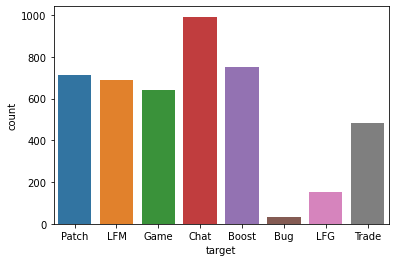

In [4]:
# Let's see what are target labels are.
sns.countplot(x='target', data= original_df);

With the chart above, I know there are duplicates because Boost, LFM (looking for members), LFG (looking for group), and Trade are highly repetive in Trade Chat. I'll be dropping duplicates in the Data Clean Up and Tokenization section.

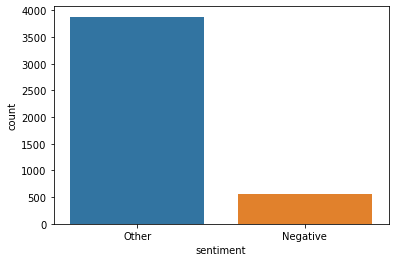

In [5]:
# Let's see what are sentiment labels are.
sns.countplot(x='sentiment', data= original_df);

There is very little negative sentiment in the entire data set, but it will become more apparent when grouping our target values into three catagories: Chat, Game, and Service. This is because we are only looking for chat pertaining to 'Game' to get our player feedback.

Lets check out the sentiment on all the target labels that will be grouped in 'Game' down the line.

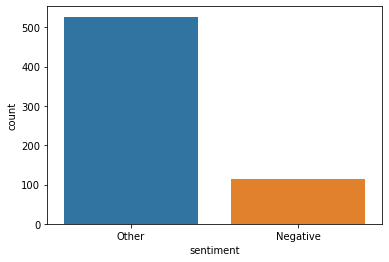

In [6]:
# Here is our sentiment so far with the Game label without grouping in Patch and Bug
sns.countplot(x='sentiment', data= original_df[original_df.target == 'Game']);

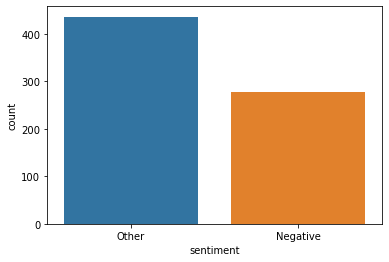

In [7]:
# Here is our sentiment so far with the Patch label without grouping in Game and Buga
sns.countplot(x='sentiment', data= original_df[original_df.target == 'Patch']);

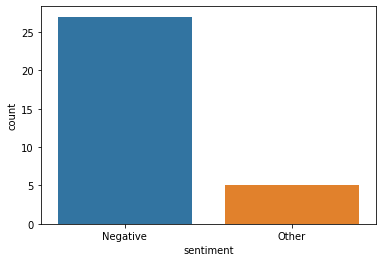

In [8]:
# Here is our sentiment so far with the Bug label without grouping in Patch and game
sns.countplot(x='sentiment', data= original_df[original_df.target == 'Bug']);

## <b><u>Data Clean Up and Tokenization</u></b> <a class="anchor" id="Data_Clean_Up_and_Tokenization"></a>

For our data clean up, I will need first reduce our target labels into three catagories: Chat, Game, and Service.

In [9]:
# Creating a copy of the orginal dataframe
df = original_df.copy()

# grouping the 9 labels into 3 general labels
df.target.replace(['Patch', 'Bug', 'Game'], 'Game', inplace=True)
df.target.replace(['Boost', 'LFM', 'LFG', 'Trade'], 'Service', inplace=True)

df.target.value_counts()

Service    2072
Game       1385
Chat        992
Name: target, dtype: int64

We see that Service now has a greater amount records when compared to Game and Chat, but that will soon change when we remove the duplicates from that catagory.

In [10]:
# Seperating the Service class to drop duplicates since the text 
# here is mainly repetitive and will cause major overfitting down the line
service_target = df[df.target == 'Service'].copy()
rest_target = df[df.target != 'Service'].copy()

service_target.drop_duplicates('text', inplace=True)

# combining the dataframes back together
df = pd.merge(rest_target, service_target, how="outer")

df.target.value_counts()

Game       1385
Chat        992
Service     578
Name: target, dtype: int64

Now we tokenize the data. This will lower case the text as well as remove any nonstandard characters.

In [67]:
# Importing our tokenizer and stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist

# loading in stopwords and adding data related stop words.
sw = stopwords.words('english')
sw.extend(['u','ur','im','dont','thats'])

# Instantiating my tokenizor
tokenizer = RegexpTokenizer(r"(?u)\b([a-z]+|9.2)\w*\b")

# Calling my TradeChat class to create new columns for tokenization and joined tokens.
# I also lemmatize the words for better modeling performance
df_token = tc.nlp_tokenizer(df, tokenizer, sw, stem='lemmatizer ')

df_token

,date,time,text,sentiment,target,text_tokenized,joined_tokens
0,2/22/2022,8:14:35 AM,how long will downtime be,Other,Game,"[long, downtime]",long downtime
1,2/22/2022,8:14:40 AM,8 hours,Other,Game,[hours],hours
2,2/22/2022,8:14:42 AM,few hours,Other,Game,[hours],hours
3,2/22/2022,8:14:42 AM,8 hours?,Negative,Game,[hours],hours
4,2/22/2022,8:14:42 AM,7hrs,Other,Game,[other],other
...,...,...,...,...,...,...,...
2950,2/23/2022,10:17:02 PM,tank and healer looking for late night raidin...,Other,Service,"[tank, healer, looking, late, night, raiding, ...",tank healer looking late night raiding guild pst
2951,2/23/2022,10:17:06 PM,>>one more rep<< need more motivation to get ...,Other,Service,"[one, rep, need, motivation, get, last, rep, g...",one rep need motivation get last rep get aotc ...
2952,2/23/2022,10:18:21 PM,wts spectral tiger cub,Other,Service,"[wts, spectral, tiger, cub]",wts spectral tiger cub
2953,2/23/2022,10:21:11 PM,wts +15 with my team 2500 io timed!,Other,Service,"[wts, team, io, timed]",wts team io timed


In [72]:
# Catagorizing Chat and Game to see the frequent words used.
chat_tokenized = df_token[df_token.target == 'Chat']
game_tokenized = df_token[df_token.target == 'Game']

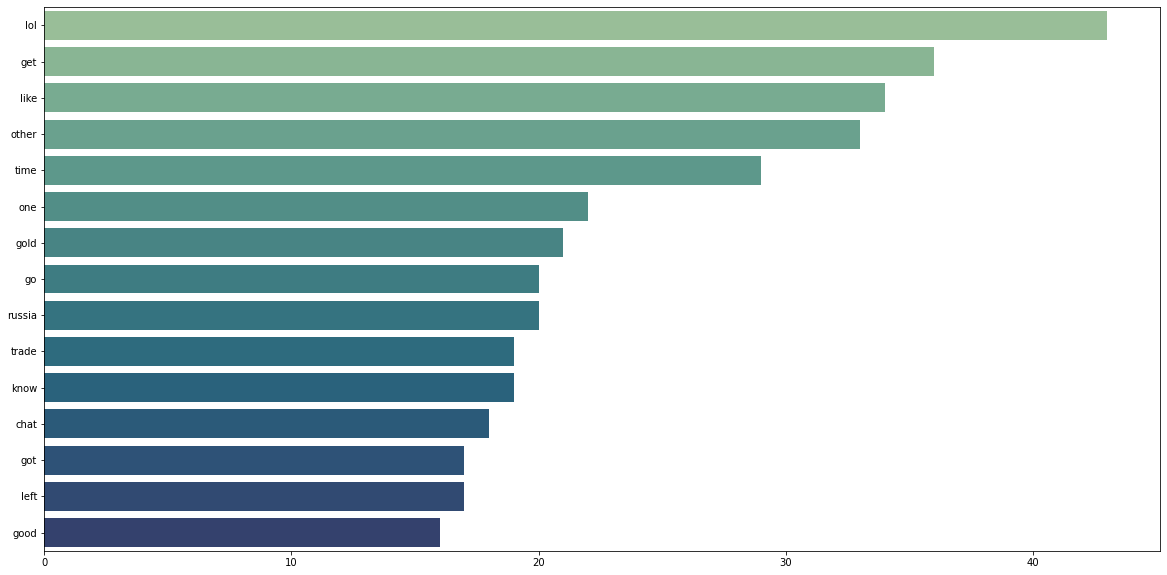

In [73]:
fdist = FreqDist(chat_tokenized.text_tokenized.explode())

top_30_words = list(zip(*fdist.most_common(15)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(x= count, y= tokens, palette='crest');

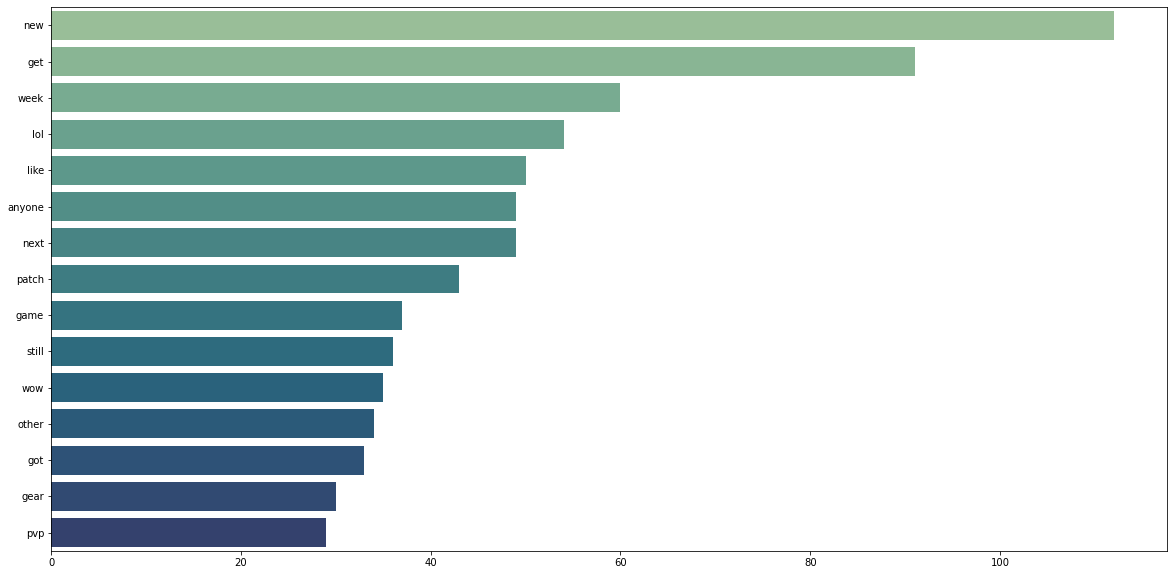

In [75]:
fdist = FreqDist(game_tokenized.text_tokenized.explode())

top_30_words = list(zip(*fdist.most_common(15)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(x= count, y= tokens, palette='crest');

Now that we have our dataframe cleaned up and tokenzied, let's get into our modeling!

## <b><u>Modeling</u></b> <a class="anchor" id="Modeling"></a>

Since we will be using different varations of our dataframe here, I'll cover what type of data each model should be fed.

1. Multiclass Model
    - Type of Data: All text that has been catagorize as either Chat, Game, and Service.
2. Sentiment Model
    - Type of Data: Only 'Game' catagorized text.
3. Topic Model
    - Type of Data: Only negative sentiment text pertaining to Game.

We will be using Stochastic Gradient Descent (SGD), Support Vector Classification (SVC), and Logistic Regression for modeling, so I'll need to import those libraries and some extra tools for performance evaluation.

In [12]:
# importing libraries for modeling
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC

# Importing our performance evaluators and train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from sklearn.model_selection import train_test_split, cross_val_score


# Creating a random_state for reproducibility 
SEED = 22

### Multiclass Model <a class="anchor" id="Multiclass_Model"></a>

Now we'll perform our train test split of our dataframe

In [13]:
# Seperating our dependent and independent data
X = df_token.joined_tokens
y = df_token.target

# Creating a list to hold our labels for visualizations
mm_model_labels = ['Chat', 'Game', 'Service']

# Performing our train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=SEED)


#### Base Models <a class="anchor" id="Multi_Based_Models"></a>

Showing results for: SGD
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(random_state=22))]), 'Performace': {'CV_Accuracy': 0.7189, 'Test_Accuracy': 0.7185}}

Showing results for: SVC
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SVC(random_state=22))]), 'Performace': {'CV_Accuracy': 0.7139, 'Test_Accuracy': 0.7321}}

Showing results for: LogReg
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=22))]), 'Performace': {'CV_Accuracy': 0.7234, 'Test_Accuracy': 0.7321}}



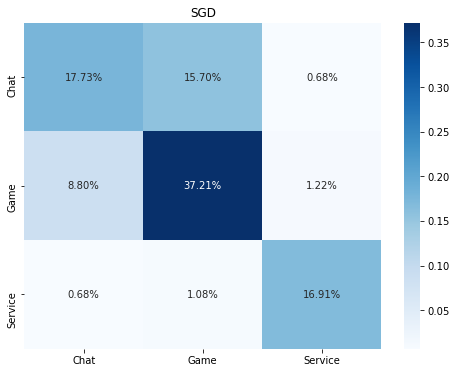

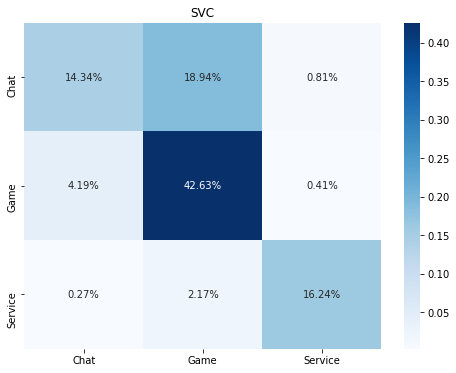

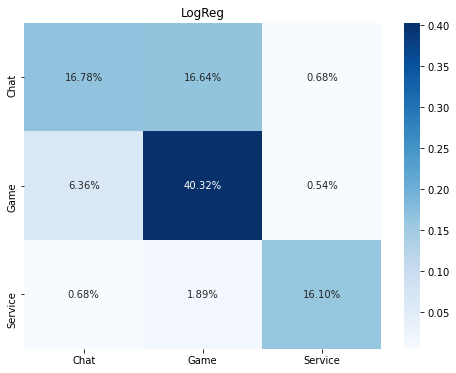

In [14]:
# Baseline SGD Model
sgd = Pipeline(
      [ ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(random_state=SEED))
        ])

# Baseline SVC Model
svc = Pipeline(
      [ ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(random_state=SEED))
      ])

# Baseline LogReg Model
lr = Pipeline(
      [ ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(random_state=SEED))
      ])

# Creating a dict to cycle through our models
models = {'SGD': sgd, 'SVC': svc, 'LogReg': lr}

# Calling the multi_run_model() method to run our models and save their performance
base_mm_model = tc.multi_run_model(models, X_train, y_train, X_test, y_test, mm_model_labels)

#### Tuned Models <a class="anchor" id="Multi_Tuned_Models"></a>

Showing results for: SGD
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(class_weight='balanced', loss='log',
                               random_state=22))]), 'Performace': {'CV_Accuracy': 0.7446, 'Test_Accuracy': 0.77}}

Showing results for: SVC
{'Model': Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SVC(C=1, class_weight='balanced', gamma='auto',
                     kernel='linear', random_state=22))]), 'Performace': {'CV_Accuracy': 0.7419, 'Test_Accuracy': 0.7618}}

Showing results for: LogReg
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=5, class_weight='balanced',
                                    random_state=22, solver='liblinear'))]), 'Performace': {'CV_Accuracy': 0.7486, 'Test

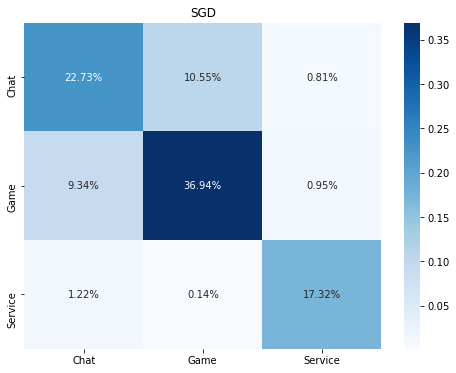

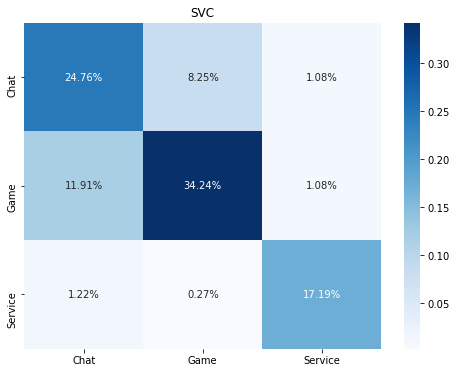

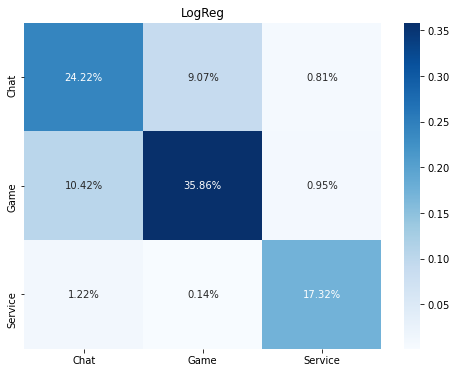

In [15]:
# Tuned SGD Model
sgd = Pipeline(
      [ ('vect', CountVectorizer(ngram_range=(1,1))),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='log', 
                              class_weight = 'balanced',
                              random_state=SEED))
        ])

# Tuned SVC Model
svc = Pipeline(
      [ ('vect', CountVectorizer(ngram_range=(1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(C=1, 
                    class_weight = 'balanced', 
                    degree = 3, 
                    gamma = 'auto', 
                    kernel= 'linear', 
                    random_state=SEED))
      ])

# Tuned LogReg Model
lr = Pipeline(
      [ ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(C=5, 
                                   class_weight = 'balanced', 
                                   multi_class= 'auto', 
                                   penalty = 'l2', 
                                   solver= 'liblinear',
                                   random_state=SEED))
      ])

# Creating a dict to cycle through our models
models = {'SGD': sgd, 'SVC': svc, 'LogReg': lr}

# Calling the multi_run_model() method to run our models and save their performance
tuned_mm_model = tc.multi_run_model(models, X_train, y_train, X_test, y_test, mm_model_labels)

In [16]:
base_mm_model

{'SGD': {'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                  ('clf', SGDClassifier(random_state=22))]),
  'Performace': {'CV_Accuracy': 0.7189, 'Test_Accuracy': 0.7185}},
 'SVC': {'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                  ('clf', SVC(random_state=22))]),
  'Performace': {'CV_Accuracy': 0.7139, 'Test_Accuracy': 0.7321}},
 'LogReg': {'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                  ('clf', LogisticRegression(random_state=22))]),
  'Performace': {'CV_Accuracy': 0.7234, 'Test_Accuracy': 0.7321}}}

In [17]:
tuned_mm_model

{'SGD': {'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                  ('clf',
                   SGDClassifier(class_weight='balanced', loss='log',
                                 random_state=22))]),
  'Performace': {'CV_Accuracy': 0.7446, 'Test_Accuracy': 0.77}},
 'SVC': {'Model': Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                  ('tfidf', TfidfTransformer()),
                  ('clf',
                   SVC(C=1, class_weight='balanced', gamma='auto',
                       kernel='linear', random_state=22))]),
  'Performace': {'CV_Accuracy': 0.7419, 'Test_Accuracy': 0.7618}},
 'LogReg': {'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                  ('clf',
                   LogisticRegression(C=5, class_weight='balanced',
                                      random_state=22, solver='liblinear'))]),
  'Performace': {'CV_Accuracy': 0.7486, 'Test_Accuracy': 0.774}}}

We'll go over the performance in the upcoming Results and Evaluation section.

### Sentiment Model <a class="anchor" id="Sentiment_Model"></a>

For our sentiment models, we need to feed only 'Game' labeled text, so we'll need to create a seperate dataframe for modeling.

In [18]:
# Selecting only Game labeled data points
sm_df_token = df_token[df_token.target == 'Game'].copy()

sm_df_token.sentiment.value_counts()

Other       968
Negative    417
Name: sentiment, dtype: int64

There is quite a bias here, so I down sampled the data and saved it as down_sampled.csv for reproducibility.

In [55]:
sm_df_token = pd.read_csv('data\down_sampled.csv', index_col=0)

sm_df_token.sentiment.value_counts()

Negative    417
Other       417
Name: sentiment, dtype: int64

That's better! Let's get our X and y variable and perform a new train test split

In [20]:
# Seperating our dependent and independent data
X = sm_df_token.joined_tokens
y = sm_df_token.sentiment.replace(['Negative','Other'],[0,1])

# Creating a list to hold our labels for visualizations
sm_model_labels = ['Negative', 'Non-negative']

# Performing our train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=SEED)


#### Base Models <a class="anchor" id="Sent_Based_Models"></a>

Showing results for: SGD
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(random_state=22))]), 'Performace': {'CV_Recall': 0.6935, 'Test_Recall': 0.7204}}

Showing results for: SVC
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SVC(random_state=22))]), 'Performace': {'CV_Recall': 0.6075, 'Test_Recall': 0.7558}}

Showing results for: LogReg
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=22))]), 'Performace': {'CV_Recall': 0.6686, 'Test_Recall': 0.6827}}



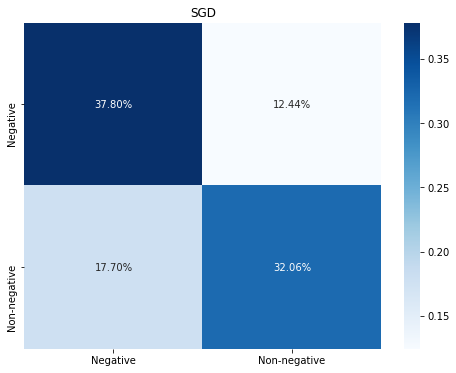

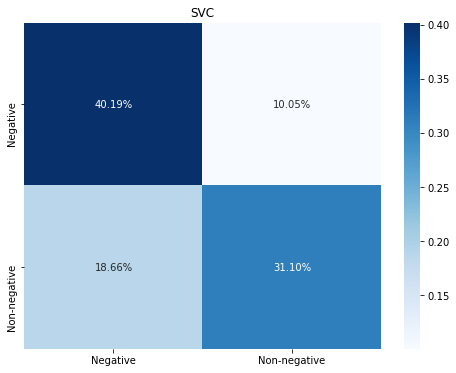

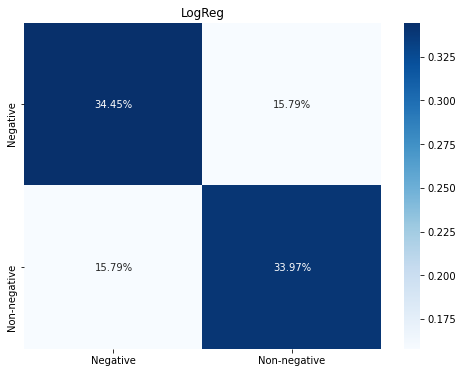

In [21]:
# Baseline SGD Model
sgd = Pipeline(
      [ ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(random_state=SEED))
        ])

# Baseline SVC Model
svc = Pipeline(
      [ ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(random_state=SEED))
      ])

# Baseline LogReg Model
lr = Pipeline(
      [ ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(random_state=SEED))
      ])

# Creating a dict to cycle through our models
models = {'SGD': sgd, 'SVC': svc, 'LogReg': lr}

# Calling the multi_run_model() method to run our models and save their performance
base_sm_model = tc.multi_run_model(models, X_train, y_train, X_test, y_test, sm_model_labels, score='recall')

#### Tuned Models <a class="anchor" id="Sent_Tuned_Models"></a>

Showing results for: SGD
{'Model': Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(class_weight='balanced', random_state=22))]), 'Performace': {'CV_Recall': 0.6424, 'Test_Recall': 0.7614}}

Showing results for: SVC
{'Model': Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SVC(C=5, gamma='auto', kernel='linear', random_state=22))]), 'Performace': {'CV_Recall': 0.6746, 'Test_Recall': 0.7273}}

Showing results for: LogReg
{'Model': Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=5, class_weight='balanced',
                                    random_state=22, solver='liblinear'))]), 'Performace': {'CV_Recall': 0.6717, 'Test_Recall': 0.7738}}



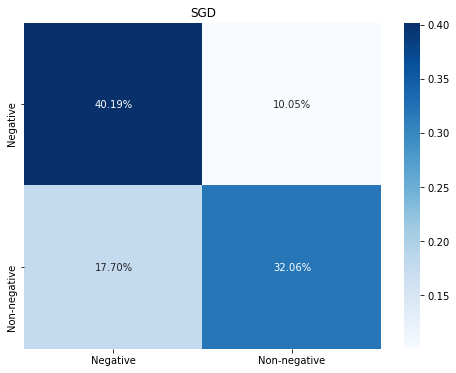

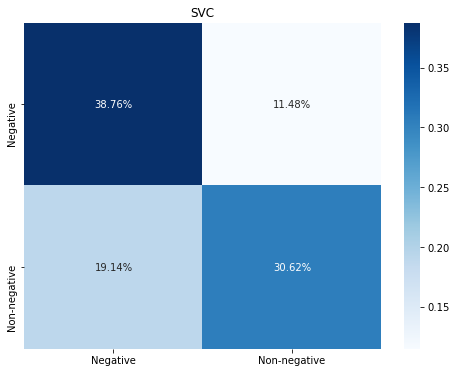

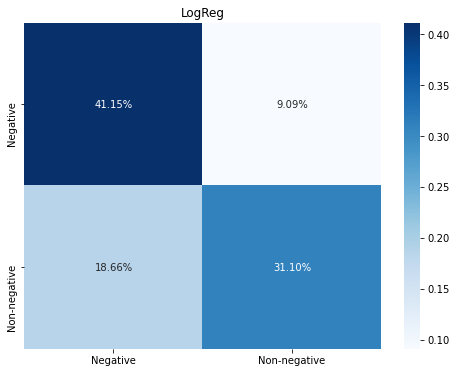

In [22]:
# Baseline SGD Model
sgd = Pipeline(
      [ ('vect', CountVectorizer(ngram_range=(1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', 
                              class_weight='balanced',
                              random_state=SEED))
        ])

# Baseline SVC Model
svc = Pipeline(
      [ ('vect', CountVectorizer(ngram_range=(1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(C= 5, 
                    degree= 3, 
                    gamma= 'auto', 
                    kernel= 'linear',
                    random_state=SEED))
      ])

# Baseline LogReg Model
lr = Pipeline(
      [ ('vect', CountVectorizer(ngram_range=(1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(C= 5, 
                                   class_weight = 'balanced', 
                                   multi_class='auto', 
                                   penalty= 'l2', 
                                   solver='liblinear', 
                                   random_state=SEED))
      ])

# Creating a dict to cycle through our models
models = {'SGD': sgd, 'SVC': svc, 'LogReg': lr}

# Calling the multi_run_model() method to run our models and save their performance
tuned_sm_model = tc.multi_run_model(models, X_train, y_train, X_test, y_test, sm_model_labels, score='recall')

In [23]:
base_sm_model

{'SGD': {'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                  ('clf', SGDClassifier(random_state=22))]),
  'Performace': {'CV_Recall': 0.6935, 'Test_Recall': 0.7204}},
 'SVC': {'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                  ('clf', SVC(random_state=22))]),
  'Performace': {'CV_Recall': 0.6075, 'Test_Recall': 0.7558}},
 'LogReg': {'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                  ('clf', LogisticRegression(random_state=22))]),
  'Performace': {'CV_Recall': 0.6686, 'Test_Recall': 0.6827}}}

In [24]:
tuned_sm_model

{'SGD': {'Model': Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                  ('tfidf', TfidfTransformer()),
                  ('clf',
                   SGDClassifier(class_weight='balanced', random_state=22))]),
  'Performace': {'CV_Recall': 0.6424, 'Test_Recall': 0.7614}},
 'SVC': {'Model': Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                  ('tfidf', TfidfTransformer()),
                  ('clf',
                   SVC(C=5, gamma='auto', kernel='linear', random_state=22))]),
  'Performace': {'CV_Recall': 0.6746, 'Test_Recall': 0.7273}},
 'LogReg': {'Model': Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                  ('tfidf', TfidfTransformer()),
                  ('clf',
                   LogisticRegression(C=5, class_weight='balanced',
                                      random_state=22, solver='liblinear'))]),
  'Performace': {'CV_Recall': 0.6717, 'Test_Recall': 0.7738}}}

Again, I will explain our results and the issues undersampling causes/solves in the Results and Evaluation section.

### Topic Model <a class="anchor" id="Topic_Model"></a>

I used a Gibbs Sampling Dirichlet Multinomial Mixture, or GDSMM for short, for my topic model. It is essentially a modified Latent Dirichlet Allocation (LDA) which assumes that a document only has one topic. This is different than LDA which assumes that a document can have multiple topics. This is perfect for what we’re are hoping to accomplish when looking at trade chat for player feedback since the text is usually short and to the point. Here we have the top eight clusters that the model provided.

So a great analogy of describing GDSMM is called the, “Movie Group Approach”. Imagine a group of students (documents) who all have a list of favorite movies (words). The students are randomly assigned to K tables. At the instruction of a teacher. the students must shuffle tables with 2 rules in mind: 
1. Find a table with more students 
2. Pick a table where your film interests align with those at the table. 

You repeat this process until you reach a plateau where the number of clusters does not change. 

A downside about GDSMM is that it doesn't have all the features of LDA. By features, I mean being able to reproduce clusters and charting the process.

We will only use negative game related chat here to create our player feedback.

In [25]:
# importing the GDSMM model
from gsdmm import MovieGroupProcess
import gensim

In [26]:
# further filtering of text with only negative sentiment
tm_df_token = sm_df_token[sm_df_token.sentiment == "Negative"]

tm_df_token.sentiment.value_counts()

Negative    417
Name: sentiment, dtype: int64

#### GDSMM: Short Text Clustering <a class="anchor" id="GDSMM"></a>

In [27]:
# assigning the tokenized text into docs
docs = tm_df_token.text_tokenized

# establishing our Dictionary object
dictionary = gensim.corpora.Dictionary(docs)

# checking the number of non zero elements
dictionary.num_nnz

1790

In [28]:
# grabbing or voacb length
vocab_len = len(dictionary)

vocab_len

881

In [29]:
# instancing the model and fitting it to our data and vocab length
gsdmm = MovieGroupProcess(K=50, alpha=0.1, beta=0.1, n_iters=30)
y = gsdmm.fit(docs, vocab_len)

In stage 0: transferred 376 clusters with 50 clusters populated
In stage 1: transferred 301 clusters with 42 clusters populated
In stage 2: transferred 260 clusters with 40 clusters populated
In stage 3: transferred 244 clusters with 36 clusters populated
In stage 4: transferred 231 clusters with 35 clusters populated
In stage 5: transferred 243 clusters with 30 clusters populated
In stage 6: transferred 235 clusters with 31 clusters populated
In stage 7: transferred 247 clusters with 29 clusters populated
In stage 8: transferred 234 clusters with 30 clusters populated
In stage 9: transferred 229 clusters with 34 clusters populated
In stage 10: transferred 213 clusters with 29 clusters populated
In stage 11: transferred 212 clusters with 30 clusters populated
In stage 12: transferred 222 clusters with 31 clusters populated
In stage 13: transferred 218 clusters with 29 clusters populated
In stage 14: transferred 215 clusters with 28 clusters populated
In stage 15: transferred 218 cluste

In [30]:
# Grabbing the number of docs per topic
doc_count = np.array(gsdmm.cluster_doc_count)

# Checking which clusters had the highest number of docs inside
top_index = doc_count.argsort()[-15:][::-1]
print('Top Clusters:', top_index)

Top Clusters: [18  1 40 34  4 31 43 46 35  9 41 32 28  3 44]


In [31]:
# Checking what is inside in each cluster using a method from
# our TradeChat class
tc.top_words(gsdmm.cluster_word_distribution, top_index, 15)


Cluster 18 : [('org', 13), ('oribos', 12), ('lol', 12), ('broken', 9), ('game', 6), ('broke', 5), ('think', 5), ('portals', 4), ('bugged', 4), ('get', 4), ('would', 4), ('k', 4), ('port', 3), ('rn', 3), ('cant', 3)]

Cluster 1 : [('new', 15), ('patch', 13), ('game', 10), ('lol', 8), ('day', 8), ('zone', 7), ('never', 6), ('like', 5), ('dead', 5), ('imagine', 4), ('gear', 4), ('always', 3), ('server', 3), ('whole', 3), ('gonna', 3)]

Cluster 40 : [('new', 12), ('like', 10), ('set', 7), ('looks', 5), ('sets', 5), ('gear', 4), ('priest', 3), ('lmao', 3), ('trash', 3), ('look', 3), ('hunter', 2), ('wtf', 2), ('play', 2), ('pvp', 2), ('drops', 2)]

Cluster 34 : [('going', 7), ('wtf', 5), ('guess', 4), ('patch', 4), ('get', 3), ('like', 3), ('raids', 3), ('fix', 3), ('quit', 3), ('wait', 2), ('stuff', 2), ('negative', 2), ('mounts', 2), ('relog', 1), ('rate', 1)]

Cluster 4 : [('servers', 5), ('shit', 4), ('wow', 4), ('cuz', 4), ('even', 3), ('cant', 3), ('gold', 3), ('hours', 3), ('today',

Now that we have our clusters, let's take a look at our top word clouds. In the case where the top clusters change and break the below word clouds, print the top index and place a number from the list with in the brackets of cluster_words.

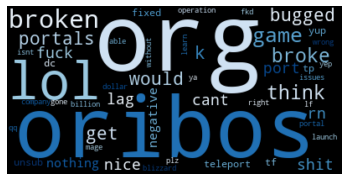

In [40]:
# Import wordcloud library
from wordcloud import WordCloud

# Get topic word distributions from gsdmm model
cluster_words = gsdmm.cluster_word_distribution


# creating a word cloud
wordcloud = WordCloud(max_words=50, colormap='Blues').generate_from_frequencies(cluster_words[18])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

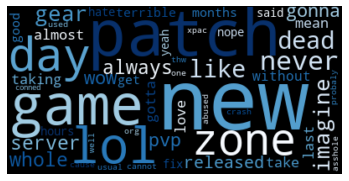

In [41]:
# creating a word cloud
wordcloud = WordCloud(max_words=50, colormap='Blues').generate_from_frequencies(cluster_words[1])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

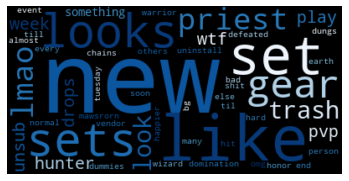

In [42]:
# creating a word cloud
wordcloud = WordCloud(max_words=50, colormap='Blues').generate_from_frequencies(cluster_words[40])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

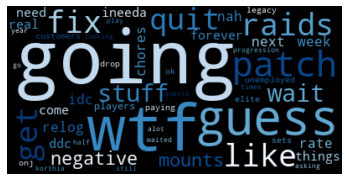

In [44]:
# creating a word cloud
wordcloud = WordCloud(max_words=50, colormap='Blues').generate_from_frequencies(cluster_words[34])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

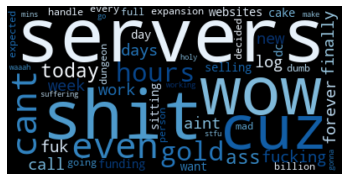

In [45]:
# creating a word cloud
wordcloud = WordCloud(max_words=50, colormap='Blues').generate_from_frequencies(cluster_words[4])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

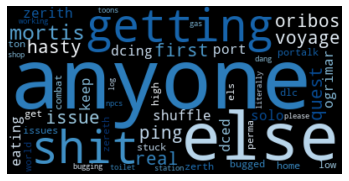

In [46]:
# creating a word cloud
wordcloud = WordCloud(max_words=50, colormap='Blues').generate_from_frequencies(cluster_words[31])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

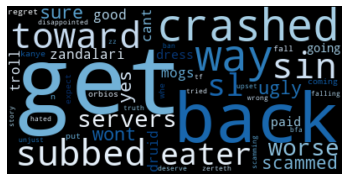

In [47]:
# creating a word cloud
wordcloud = WordCloud(max_words=50, colormap='Blues').generate_from_frequencies(cluster_words[43])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

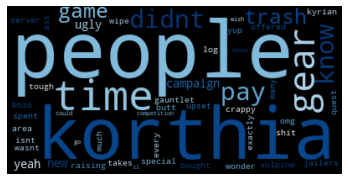

In [48]:
# creating a word cloud
wordcloud = WordCloud(max_words=50, colormap='Blues').generate_from_frequencies(cluster_words[46])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

## <b><u>Results and Evaluation</u></b> <a class="anchor" id="Results_and_Evaluation"></a>

### Multiclass Model 

In [61]:
for model, values in base_mm_model.items():
    print(model)
    print(values['Performace'])

SGD
{'CV_Accuracy': 0.7189, 'Test_Accuracy': 0.7185}
SVC
{'CV_Accuracy': 0.7139, 'Test_Accuracy': 0.7321}
LogReg
{'CV_Accuracy': 0.7234, 'Test_Accuracy': 0.7321}


The base models for the multiclass had a decent starting point for accuracy, but the tuned models accuracy increased across the board!

In [62]:
for model, values in tuned_mm_model.items():
    print(model)
    print(values['Performace'])

SGD
{'CV_Accuracy': 0.7446, 'Test_Accuracy': 0.77}
SVC
{'CV_Accuracy': 0.7419, 'Test_Accuracy': 0.7618}
LogReg
{'CV_Accuracy': 0.7486, 'Test_Accuracy': 0.774}


Here we have our best accuracy score of ~77.4% from Logistic Regression. The score has a 30% lift from randomly labeling the 'Game' catagory.

<img width=45% src="images\multi_logreg.PNG">

Looking at the confusion matrix, we can see that the model did a decent job at classifying text, but it does have trouble when it comes to Chat and Game related text.

### Sentiment Model 

In [63]:
for model, values in base_sm_model.items():
    print(model)
    print(values['Performace'])

SGD
{'CV_Recall': 0.6935, 'Test_Recall': 0.7204}
SVC
{'CV_Recall': 0.6075, 'Test_Recall': 0.7558}
LogReg
{'CV_Recall': 0.6686, 'Test_Recall': 0.6827}


Our sentiment model's data was down sampled which resulted in higher recall score for unseen data, but not much of result for its cross validated recall score.

In [64]:
for model, values in tuned_sm_model.items():
    print(model)
    print(values['Performace'])

SGD
{'CV_Recall': 0.6424, 'Test_Recall': 0.7614}
SVC
{'CV_Recall': 0.6746, 'Test_Recall': 0.7273}
LogReg
{'CV_Recall': 0.6717, 'Test_Recall': 0.7738}


We see that Logistic Regression takes the crown again with a test recall score of ~77.38%, but has a cross validated recall score of 67.17%. That's is still not to bad considering we downsampled the dataset to make the playing field 50/50.

<img width=45% src="images\sent_logreg.PNG">

The model was able to predict a majority of the negative sentiment but has issues with misclassification of non-negative on the bottom left square. Since classifying negative is important for finding player feedback, the model may need more data to train on.

### Topic Model 

<img width=80% src="images\topic_clusters.PNG">

Our topic model of GDSMM did great work with clustering by topic. Through the cluster, we can see that players had a lot of trouble with lag and disconnects on the launch of patch 9.2. Another topic was tier sets. More specifically, Hunter and Priest armor sets seem to be met with negative sentiment by the playerbase. A third topic I could recognize was about a bugged quest. This is what I consider a major find since this specific quest, "A Hasty Voyage", is what starts your jouney into the new zone introduced in 9.2, Eternity's End!

## <b><u>Suggestions</u></b> <a class="anchor" id="Suggestions"></a>
For our suggestions based on player feedback, Blizzard Entertainment should focus on three areas. 
1. Increase server stability during launch of new content. 

2. Have players vote for their class armor set appearance to help reduce the amount of negative sentiment towards it. 

3. Debug the quest called “A Hasty Voyage” to allow players to enter the new zone introduced in patch 9.2, Eternity's End without issues.

## <b><u>Future Research</u></b> <a class="anchor" id="Future_Research"></a>
Moving into future reasearch, I would focus on the following:

1. Gather data from all servers and regions to highlight topics with the most negative sentiment. This will also allow us to find the differences between player interests per region and it could help my models better predict topic and sentiment.

2. Place a non-player character, better known as NPC, in all major player hubs where players can be given sentiment based multiple choice questions on current and new game features. This will allow for a constant and friction less flow of player feedback.

3. Adapt my models to track harassment and block it so as to not deter newer players from World of Warcraft. 

## <b><u>For More Information</u></b> <a class="anchor" id="Contact"></a>
Feel free to contact me through the below links if you have any questions.

Edel Prado | Data Scientist: 
[ [LinkedIn](https://www.linkedin.com/in/edel-prado-jr/) ] [ [Email](edel.prado.jr@gmail.com) ]